# World Models

### 1. V-Model

### 2. M-Model

### 3. C-Model



In [1]:
import gym
from gym.spaces import Box
import numpy as np
print(gym.__version__)
try:
    import cv2
except ImportError:
    cv2 = None
    
#from pyvirtualdisplay import Display
#_display = Display(visible=False, size=(1400, 900))
#_ = _display.start()

0.17.3


In [2]:
# bring observation in desired shape and scale observation between 0 and 1
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
class ObservationWrapper(gym.Wrapper):
    def __init__(self, env, image_size=(64,64,3), scale_obs=True):
        super().__init__(env)
        self.shape = image_size
        self.screen_size = image_size[0]
        self.scale_obs = scale_obs
        _low, _high, _obs_dtype = (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        self.observation_space = Box(low=_low, high=_high, shape=image_size, dtype=_obs_dtype)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self._get_obs(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self._get_obs(obs)
        
    
    def _get_obs(self, obs):

        obs = cv2.resize(obs, (self.screen_size, self.screen_size))#, interpolation=cv2.INTER_AREA)

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        return obs
    
class PytorchWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs, reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs
        
        

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal

import matplotlib.pyplot as plt

# V-Model

In [114]:
class VAE():
    def __init__(self, state_size, latent_size_N=32, device="cpu"):
              
        self.encoder = Encoder(state_size, latent_size_N).to(device)
        self.decoder = Decoder(state_size, latent_size_N).to(device)
        self.device = device
        
        self.params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = optim.Adam(params=self.params, lr=0.001)
        #self.optimizer_decoder = optim.Adam(params=self.decoder.parameters(), lr=0.0001)
        
    def forward(self, image: torch.Tensor)-> torch.Tensor:
        
        assert image.shape == (image.shape[0] ,3, 64, 64), "Input Image as wrong shape!"
        mu, sig = self.encoder(image)
        encoded = self.sample(mu, sig)
        
        decoded = self.decoder(encoded)
        return decoded, (mu, sig)
    
    def encode_state(self, image: torch.Tensor, return_mu=False)-> torch.Tensor:
        assert image.shape == (image.shape[0], 3, 64, 64), "Input Image as wrong shape!"
        (mu, logsig) = self.encoder(image)
        encoded = self.sample(mu, logsig, return_mu)
        return encoded
    
    def sample(self, mu, logsig, return_mu=False):
            
        #dist = Normal(mu, sig) 
        #latent_vector_z = dist.sample()
        
        # in the paper they had different sample methods this one and mu + sig *N(0,1)
        #latent_vector_z = mu + sig * torch.normal(torch.zeros(1), torch.ones(1)).to(device)
        if return_mu == True:
            return mu
        else:
            sigma = logsig.exp()
            eps = torch.randn_like(sigma)     
            return eps.mul(sigma).add_(mu)
        
    def train(self, dataloader:DataLoader)-> torch.Tensor:
        losses = {"loss1": [], "loss2": []}
        for idx, sample in enumerate(dataloader):
            
            image_batch = sample[0].to(device)
            reconstructed, (mu, sig) = self.forward(image_batch)
            
            loss_1 = kl_loss(mu, sig)
            loss_2 = l2_dist_loss(reconstructed, image_batch)
            
            self.optimizer.zero_grad()
            loss = (loss_1 + loss_2).mean()
            
            loss.backward()
            #clip_grad_norm_(self.params, 10.)
            self.optimizer.step()
            losses["loss1"].append(loss_1.detach().cpu().numpy())
            losses["loss2"].append(loss_2.detach().cpu().numpy())
        return np.mean(losses["loss1"]),np.mean(losses["loss2"]) 
            
            

def kl_loss(mu: torch.Tensor, sig:torch.Tensor)-> torch.Tensor:
    #loss = - 0.5 * (1 + torch.log(sig).pow(2) - sig.pow(2) - mu.pow(2)).sum()
    loss = -0.5 * torch.sum(1 + 2 * sig - mu.pow(2) - (2 * sig).exp())
    return loss

def l2_dist_loss(prediction:torch.Tensor, target:torch.Tensor)-> torch.Tensor:
    #return - torch.dist(target,prediction, p=2)
    return F.mse_loss(prediction, target, size_average=False)
    #return F.binary_cross_entropy(prediction, target, size_average=False)
        
class Encoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.output_mu = nn.Linear(1024, latent_size_N)
        self.output_sig = nn.Linear(1024, latent_size_N)
        #self.softplus = nn.Softplus() #use different activation?
        
    
    def forward(self, img):
        
        x = torch.relu(self.conv1(img))
        #print(x.shape)
        x = torch.relu(self.conv2(x))
        #print(x.shape)
        x = torch.relu(self.conv3(x))
        #print(x.shape)
        x = torch.relu(self.conv4(x))
        #print(x.shape)
        
        mu = self.output_mu(x.flatten(1)) #torch.tanh()
        log_sig = self.output_sig(x.flatten(1))#self.softplus()
        #sig = torch.sqrt(var)
                    
        return (mu, log_sig)

        
class Decoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Decoder, self).__init__()
        
        self.in_linear = nn.Linear(32, 1024)
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2)
        
    def forward(self, latent_vector):
        
        x = torch.relu(self.in_linear(latent_vector)).unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.deconv1(x))
        #print(x.shape)
        x = torch.relu(self.deconv2(x))
        #print(x.shape)
        x = torch.relu(self.deconv3(x))
        #print(x.shape)
        x = torch.sigmoid(self.deconv4(x))
        #print(x.shape)
        return x

# Create Samples with random policy


In [115]:
env = gym.make("CarRacing-v0")
env = MaxAndSkipEnv(env)
env = ObservationWrapper(env, image_size=(64,64,3), scale_obs=True)
env = PytorchWrapper(env)
state_size = env.observation_space.shape
action_size = env.action_space.shape[0]

/home/sebastian/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
Episodes = 5
samples = {"states":[], "actions": [], "next_states": [], "rewards": [], "dones":[]}

for ep in range(Episodes):
    done=False
    state = env.reset()
    step_count = 0 ## First ~50 steps is zooming to start position. not needed for training
    while True:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        step_count += 1
        
        if step_count > 50:
            samples["states"].append(state)
            samples["next_states"].append(next_state)
            samples["actions"].append(action)
            samples["rewards"].append(reward)
            samples["dones"].append(done)
        state = next_state
        if done:
            print("Ep: {} | Sample size: {}".format(ep, len(samples["states"])))
            break
    env.close()
        

Track generation: 1035..1298 -> 263-tiles track
Ep: 0 | Sample size: 200
Track generation: 1227..1538 -> 311-tiles track
Ep: 1 | Sample size: 400
Track generation: 1049..1319 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1223..1535 -> 312-tiles track
Ep: 2 | Sample size: 600
Track generation: 1106..1387 -> 281-tiles track
Ep: 3 | Sample size: 800
Track generation: 1176..1474 -> 298-tiles track
Ep: 4 | Sample size: 1000


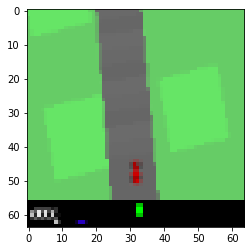

In [7]:
plt.imshow(samples["states"][4].squeeze().reshape(64,64,3))

# Create Dataset 

In [7]:
# Create Dataset of states
set = torch.cat(samples["states"], dim=0)
dataset = TensorDataset(set)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Build V-Model

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
V_model = VAE(state_size=(3, 64, 64), device=device)
print("Using: {}".format(device))

Using: cpu


In [11]:
Epochs = 150
losses = {"loss1": [], "loss2": [], "loss": []}
for i in range(Epochs):
    loss1, loss2 = V_model.train(dataloader)
    print("\rEpoch: {} | kl_loss: {:.2f} | l2_loss: {:.2f} | combines loss: {:.2f}".format(i, loss1, loss2, loss1+loss2), end="", flush=True)
    if i % 10 == 0:
        print("\rEpoch: {} | kl_loss: {:.2f} | l2_loss: {:.2f} | combines loss: {:.2f}".format(i, loss1, loss2, loss1+loss2))
        
    losses["loss1"].append(loss1)    
    losses["loss2"].append(loss2)    
    losses["loss"].append(loss1+loss2)

Epoch: 0 | kl_loss: 71.90 | l2_loss: 169813.84 | combines loss: 169885.75
Epoch: 10 | kl_loss: 21.05 | l2_loss: 28028.80 | combines loss: 28049.84
Epoch: 20 | kl_loss: 32.07 | l2_loss: 25725.03 | combines loss: 25757.10
Epoch: 30 | kl_loss: 55.31 | l2_loss: 24758.92 | combines loss: 24814.22
Epoch: 40 | kl_loss: 696.14 | l2_loss: 20248.38 | combines loss: 20944.52
Epoch: 50 | kl_loss: 681.27 | l2_loss: 16865.11 | combines loss: 17546.38
Epoch: 60 | kl_loss: 836.19 | l2_loss: 14402.72 | combines loss: 15238.91
Epoch: 70 | kl_loss: 1080.46 | l2_loss: 12009.75 | combines loss: 13090.21
Epoch: 80 | kl_loss: 1121.50 | l2_loss: 10920.79 | combines loss: 12042.28
Epoch: 90 | kl_loss: 1168.48 | l2_loss: 10220.07 | combines loss: 11388.54
Epoch: 100 | kl_loss: 1433.07 | l2_loss: 9053.36 | combines loss: 10486.43
Epoch: 110 | kl_loss: 1532.24 | l2_loss: 8559.24 | combines loss: 10091.48
Epoch: 120 | kl_loss: 1603.85 | l2_loss: 8094.52 | combines loss: 9698.372
Epoch: 130 | kl_loss: 1574.58 | l2_

<function matplotlib.pyplot.show(close=None, block=None)>

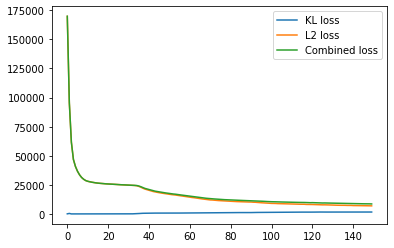

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses["loss1"], label="KL loss")
plt.plot(losses["loss2"], label="L2 loss")
plt.plot(losses["loss"], label="Combined loss")
plt.legend()

plt.show

In [13]:
# safe / load state dict

torch.save(V_model.encoder.state_dict(), "Encoder.pth")
torch.save(V_model.decoder.state_dict(), "Decoder.pth")

In [118]:
V_model.encoder.load_state_dict(torch.load("VAE_models/Encoder.pth", map_location=torch.device('cpu')))
V_model.decoder.load_state_dict(torch.load("VAE_models/Decoder.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

# Observe training results

State number: 494


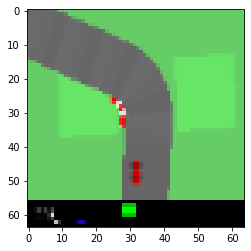

In [111]:
len(samples["states"])
nr = np.random.randint(len(samples["states"]))
print("State number:", nr)
example_image = samples["states"][nr]
# select example image
plt.imshow(example_image.squeeze().reshape(64,64,3))

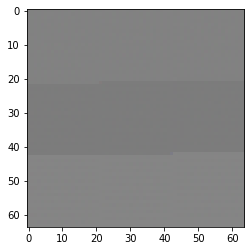

In [112]:
# view reconstructed image
reconstr, _ = V_model.forward(example_image.to(device))
plt.imshow(reconstr.detach().cpu().numpy().reshape(64,64,3))

# M-Model

In [321]:
class MModel(nn.Module):
    def __init__(self, action_size, latent_size=32, hidden_size=256, n_gaussians=5, rnn_type="LSTM"):
        super(MModel, self).__init__()
        
        self.input_shape = action_size+latent_size
        self.action_size = action_size
        self.latent_size = latent_size
        self.n_gaussians = n_gaussians
        
        if rnn_type == "LSTM":
            self.rnn_layer = nn.LSTM(self.input_shape, hidden_size, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn_layer = nn.GRU(self.input_shape, hidden_size, batch_first=True)
            
        #self.gmm_layer = nn.Linear(hidden_size,  (2 * latent_size + 1) * n_gaussians + 2) #(2 * latent_size + 1) * n_gaussians + 2
        self.pi_layer = nn.Linear(hidden_size, latent_size*n_gaussians)
        self.mu_layer = nn.Linear(hidden_size,  latent_size * n_gaussians)
        self.sig_layer = nn.Linear(hidden_size, latent_size * n_gaussians)
        self.reward_layer = nn.Linear(hidden_size, 1)
        self.done_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, latent_vector: torch.Tensor, action:torch.Tensor, hidden_state=None)-> torch.Tensor:
        """ Simple forward pass with the RNN """
        
        assert latent_vector.shape == (latent_vector.shape[0], latent_vector.shape[1], self.latent_size), "Latent vector has the wrong shape!"
        assert action.shape == (action.shape[0], action.shape[1], self.action_size), "Action batch has the wrong shape!"
        
        input_tensor = torch.cat((latent_vector, action),dim=-1)
        assert input_tensor.shape == (action.shape[0], action.shape[1], self.input_shape), "input_tensor has wrong shape!"
        
        output, hidden_state = self.rnn_layer(input_tensor, hidden_state)
        
        (pi, mu, sigma, rs, ds) = self.get_gauss_coeffs(output)
        return (pi, mu, sigma, rs, ds), hidden_state
    
    
    def get_gauss_coeffs(self, y:torch.Tensor):
        
        batch_size = y.shape[0]
        sequence_length = y.shape[1]

        
#         gmm = self.gmm_layer(y)
    
#         stride = self.n_gaussians * self.latent_size

#         mu = gmm[:, :, :stride]
#         mu = mu.view(batch_size, sequence_length, self.n_gaussians, self.latent_size)

#         sigma = gmm[:, :, stride:2 * stride]
#         sigma = sigma.view(batch_size, sequence_length, self.n_gaussians, self.latent_size)
#         sigma = torch.exp(sigma)

#         pi = gmm[:, :, 2 * stride: 2 * stride + self.n_gaussians]
#         pi = pi.view(batch_size, sequence_length, self.n_gaussians)
#         logpi = F.log_softmax(pi, dim=-1)

#         rs = gmm[:, :, -2] # needed later if start dreaming

#         ds = gmm[:, :, -1] # needed later if start dreaming

#### method 2
        mu = self.mu_layer(y)
        mu = mu.view(batch_size, sequence_length, self.n_gaussians, self.latent_size)
        
        sigma = self.sig_layer(y)
        sigma = sigma.view(batch_size, sequence_length, self.n_gaussians, self.latent_size)
        sigma = torch.exp(sigma)
        
        pi = self.pi_layer(y)
        pi = pi.view(batch_size, sequence_length, self.n_gaussians, self.latent_size)
        pi = F.softmax(pi, dim=-1)
        
        rs = self.reward_layer(y).squeeze()
        ds = F.sigmoid(self.done_layer(y)).squeeze()       
        
        return pi, mu, sigma, rs, ds
    
    def predict_next_z(self,latent_vector: torch.Tensor, action:torch.Tensor, tau: float, hidden_state=None)-> torch.Tensor:
        """ Predicts the next Latent Vector Z """
        values, hidden_state = self.forward(latent_vector, action, hidden_state)
        pi, mu, sigma, rs, ds = values[0], values[1], values[2], values[3], values[4]
        
        dist = Normal(mu, sigma*tau)
        z_ = (pi*dist.sample()).sum(2)
        
        return (z_, rs, ds), hidden_state
        
# # M-Model loss calculation
# def mdn_loss_fn(y, logpi, mu, sigma):
#     print(logpi.shape)
#     dist = Normal(mu, sigma)

#     log_probs = dist.log_prob(y)
#     print(log_probs.shape)
#     log_probs = logpi + torch.sum(log_probs, dim=-1)
#     max_log_probs = torch.max(log_probs, dim=-1, keepdim=True)[0]
#     log_probs = log_probs - max_log_probs

#     probs = torch.exp(log_probs)
#     sum_probs = torch.sum(probs, dim=-1)
#     log_prob = max_log_probs.squeeze() + torch.log(sum_probs)
    
#     return -log_prob.mean()

def mdn_loss_fn(y, out_pi, out_mu, out_sigma):
    y = y.view(-1, 16, 1, 32)
    result = Normal(loc=out_mu, scale=out_sigma)
    result = torch.exp(result.log_prob(y))
    result = torch.sum(result * out_pi, dim=2)
    result = -torch.log( result)
    return torch.mean(result)


def criterion(y, pi, mu, sigma):
    #y = y.unsqueeze(-2) 
    return mdn_loss_fn(y, pi, mu, sigma)

def get_reward_loss(reward, pred_reward):
    return F.mse_loss(pred_reward, reward)

def get_done_loss(done, done_pred):
    return F.binary_cross_entropy(done_pred, done)  #binary_cross_entropy_with_logits <- if no softmax activation

In [322]:
device = "cpu"# torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
action_size = env.action_space.shape[0]
m_model = MModel(action_size=action_size).to(device)

In [323]:
M_optimizer = optim.RMSprop(params=m_model.parameters(), lr=1e-3, alpha=.9)
M_optimizer = optim.Adam(params=m_model.parameters(), lr=1e-3)#, alpha=.9)


In [226]:
m_actions = samples["actions"]
m_actions = torch.from_numpy(np.array(m_actions))
m_states = torch.cat(samples["states"], dim=0)
m_next_states = torch.cat(samples["next_states"], dim=0)
m_rewards = torch.FloatTensor(samples["rewards"])
m_dones = torch.FloatTensor(samples["dones"])

seq_length = 16 
batch_size = 16
sequence_samples = {"states": [],
                    "actions": [],
                    "next_states": [],
                    "rewards": [],
                    "dones": []}


samples_ = {"states": m_states,
            "actions": m_actions,
            "next_states": m_next_states,
            "rewards": m_rewards,
            "dones": m_dones}

for key, elements in samples_.items():
    sequences = []
    #print(len(elements))
    for i in range(len(elements)-seq_length):
        sequences.append(elements[i:i+seq_length].unsqueeze(0))

    sequence_samples[key] = torch.cat(sequences)
    
dataset = TensorDataset(sequence_samples["states"], 
                        sequence_samples["actions"], 
                        sequence_samples["next_states"], 
                        sequence_samples["rewards"], 
                        sequence_samples["dones"])

m_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [77]:
def encode_batch_sequence(batch, batch_size=16, sequence_length=10, latent_size=32):
    encoded = []
    for sequence in batch:
        for sample in sequence:
            encoded.append(V_model.encode_state(sample.unsqueeze(0).to(device)))
    return torch.cat(encoded).reshape(batch_size, sequence_length, latent_size)

In [325]:
# Train M-Model:
V_model.encoder.eval()
Episodes = 10
losses = []
for ep in range(Episodes):
    ep_losses = []
    for (states, actions, next_states, rewards, dones) in m_dataloader:
        
        
        with torch.no_grad():
            z = encode_batch_sequence(states, batch_size, seq_length)
            targets = encode_batch_sequence(next_states, batch_size, seq_length)
        
        (pi, mu, sigma, rs, ds), _ = m_model(latent_vector=z,
                                   action=actions.to(device),
                                   hidden_state=None)
        
        M_optimizer.zero_grad()
        loss = criterion(targets, pi, mu, sigma)
        reward_loss = get_reward_loss(rewards, rs)
        done_loss = get_done_loss(dones, ds)
        # scaling for latent vector size (32) + reward (1) + done (1) value
        loss = (loss+reward_loss+done_loss)/(32+2) 
        loss.backward()
        M_optimizer.step()
        ep_losses.append(loss.detach().cpu().numpy())
        
    losses.append(np.mean(ep_losses))    
    print("\rEpisode: {} | Loss: {}".format(ep, np.mean(ep_losses)), end="", flush=True)
    if ep % 25 == 0:
        print("\rEpisode: {} | Loss: {}".format(ep, np.mean(ep_losses)))
        

Episode: 0 | Loss: 0.12334789335727692
Episode: 9 | Loss: 0.11451602727174759

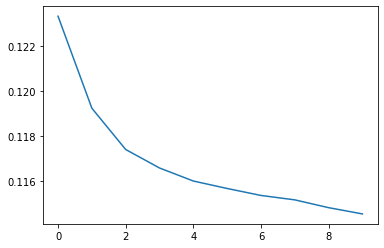

In [326]:
plt.plot(losses)

In [184]:
# safe / load state dict

torch.save(m_model.state_dict(), "M-Model_seq16_sepearate_head.pth")

In [110]:
m_model.load_state_dict(torch.load("M-Model_seq16_withR&D.pth"))

<All keys matched successfully>

# Observing learned Dreaming module

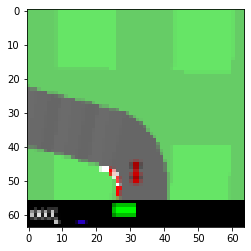

In [364]:
nr = 130
plt.imshow(samples["states"][nr].squeeze().reshape(64,64,3))

In [365]:
states = samples["states"][nr]

In [366]:
encod_st = V_model.encode_state(states).unsqueeze(0)

In [367]:
encod_st.shape

torch.Size([1, 1, 32])

In [368]:
action = torch.FloatTensor(samples["actions"][nr])#.reshape(1,16,3)
action = action.unsqueeze(0).unsqueeze(0)

In [373]:
z_1, _ = m_model.predict_next_z(encod_st, action, tau=1.1)

In [370]:
print(z_1[1])
print(samples["rewards"][nr])

tensor(-0.1234, grad_fn=<SqueezeBackward0>)
-0.3999999999999986


In [371]:
reconstructed = V_model.decoder(z_1[0].squeeze(0))

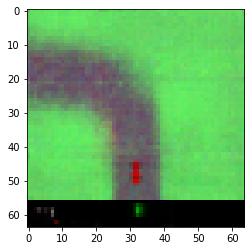

In [372]:
plt.imshow(reconstructed.detach().numpy().reshape(64,64,3))

# C-Model

In [11]:
class C_Model(nn.Module):
    def __init__(self, action_size, hidden_size=256, latent_size=32, device="cpu"):
        super(C_Model, self).__init__()
        
        self.device = device
        self.action_size = action_size
        
        self.layer_1 = nn.Linear(latent_size+(2*256), hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, action_size)
        
        
    def forward(self, latent_vector:torch.Tensor, hidden_state:torch.Tensor)-> torch.Tensor:
        """  """
        input_ = torch.cat((latent_vector, hidden_state), dim=1)
        x = torch.relu(self.layer_1(input_))
        x = torch.relu(self.layer_2(x)) 
        x = torch.tanh(self.layer_3(x)) 
        # add var to prediction as well
        return x
    
    def get_action(self, latent_vector:torch.Tensor, hidden_state:torch.Tensor)-> torch.Tensor:
        """  """

        mu = self.forward(latent_vector, torch.cat(hidden_state, dim=-1).squeeze(0))
        dist = Normal(mu, torch.ones(1).to(self.device)*0.2)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action, log_prob
    

def calc_discounted_rewards(rewards, final_state, gamma = 0.95):
    R = 0
    discounted = []
  
    for idx in reversed(range(len(rewards))):
        R = rewards[idx]+R*gamma *final_state[idx]
        discounted.insert(0,R)
    return discounted
    
def update_cmodel(log_pis:torch.Tensor, rewards:torch.Tensor)-> np.array:
    """ Updating the C-Model in a PG-Style """
    assert log_pis.shape[0] == rewards.shape[0]
    
    c_model_optim.zero_grad()
    # Normalize.
    mean = torch.mean(rewards)
    std = torch.std(rewards)
    rewards = (rewards - mean) / (std)
    
    loss = (-log_pis*(rewards-rewards.mean())).sum()
    loss.backward()
    c_model_optim.step()
    return loss.detach().cpu().numpy()

In [12]:
action_size = env.action_space.shape[0]
c_model = C_Model(action_size, device=device).to(device)

In [13]:
c_model_optim = optim.Adam(params=c_model.parameters(), lr=0.0001)

## Train without M-Model

Train the C-Model in Policy Gradient Style without the M-Model!

In [28]:
episodes = 600
c_model_rewards = []
high_action = env.action_space.high
low_action = env.action_space.low
for ep in range(episodes):
    state = env.reset()
    done = False
    episode_rewards = 0
    
    reward_batch = []
    dones_batch = []
    log_prob_batch = []
    
    while True:
        
        # run with sampled latent vector
        latent_vector_z = V_model.encode_state(state.to(device), return_mu=True)
        zero_hidden = (torch.zeros((1, 1, 256)).to(device),torch.zeros((1, 1,  256)).to(device))
        
        # run with mu and sig from encoder
        #latent_vector_z, zero_hidden = V_model.encoder(state.to(device))
        
        action, log_prob = c_model.get_action(latent_vector_z, zero_hidden)
        
        action = np.asarray(np.clip(action.detach().cpu().numpy(), a_min=low_action, a_max=high_action), dtype=np.float32).squeeze()

        state, reward, done, _ = env.step(action)
        
        reward_batch.append(reward)
        dones_batch.append(1-int(done))
        log_prob_batch.append(log_prob)
        
        episode_rewards += reward
        
        if done:
            break
            
    rewards = calc_discounted_rewards(reward_batch, dones_batch)

    loss = update_cmodel(torch.cat(log_prob_batch, dim=0),
                         torch.FloatTensor(rewards).unsqueeze(-1).to(device))
    
    del(reward_batch)
    del(dones_batch)
    del(log_prob_batch)
    c_model_rewards.append(episode_rewards)    
            
    print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss), end="", flush=True)
    if ep % 10 == 0:
        print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss))
    env.close()
    
        

Track generation: 981..1233 -> 252-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1160..1454 -> 294-tiles track
Epoch: 0 | Reward: -24.91 | Loss: -7.52
Track generation: 1198..1503 -> 305-tiles track
Epoch: 1 | Reward: -24.34 | Loss: 9.50Track generation: 1000..1254 -> 254-tiles track
Epoch: 2 | Reward: -40.71 | Loss: 17.96Track generation: 1304..1634 -> 330-tiles track
Epoch: 3 | Reward: 51.98 | Loss: -15.16Track generation: 1268..1589 -> 321-tiles track
Epoch: 4 | Reward: -31.25 | Loss: 12.43Track generation: 1334..1672 -> 338-tiles track
Epoch: 5 | Reward: -76.26 | Loss: -16.12Track generation: 1070..1342 -> 272-tiles track
Epoch: 6 | Reward: -48.34 | Loss: -39.95Track generation: 1308..1639 -> 331-tiles track
Epoch: 7 | Reward: -24.24 | Loss: -8.80Track generation: 1125..1410 -> 285-tiles track
Epoch: 8 | Reward: -71.83 | Loss: -23.41Track generation: 1279..1603 -> 324-tiles track
Epoch: 9 | Reward: -19.50 | Loss: -7.59

Epoch: 78 | Reward: 25.00 | Loss: -7.36Track generation: 1086..1362 -> 276-tiles track
Epoch: 79 | Reward: 9.09 | Loss: -4.43Track generation: 1158..1453 -> 295-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1176..1474 -> 298-tiles track
Epoch: 80 | Reward: -29.29 | Loss: 45.36
Track generation: 1049..1321 -> 272-tiles track
Epoch: 81 | Reward: -11.44 | Loss: -22.68Track generation: 1161..1455 -> 294-tiles track
Epoch: 82 | Reward: -41.98 | Loss: 0.35Track generation: 1157..1450 -> 293-tiles track
Epoch: 83 | Reward: -45.21 | Loss: -37.95Track generation: 1154..1445 -> 291-tiles track
Epoch: 84 | Reward: -17.24 | Loss: 9.45Track generation: 1051..1318 -> 267-tiles track
Epoch: 85 | Reward: -115.89 | Loss: 1.17Track generation: 1177..1475 -> 298-tiles track
Epoch: 86 | Reward: 54.88 | Loss: 20.13Track generation: 1114..1405 -> 291-tiles track
Epoch: 87 | Reward: -58.62 | Loss: 7.45Track generation: 1144..1441 -> 297-tiles tr

Epoch: 159 | Reward: -87.30 | Loss: -5.56Track generation: 1063..1333 -> 270-tiles track
Epoch: 160 | Reward: -40.52 | Loss: -47.53
Track generation: 1297..1625 -> 328-tiles track
Epoch: 161 | Reward: -148.94 | Loss: 2.81Track generation: 1303..1632 -> 329-tiles track
Epoch: 162 | Reward: -29.88 | Loss: 2.61Track generation: 1347..1694 -> 347-tiles track
Epoch: 163 | Reward: -123.75 | Loss: -30.88Track generation: 1125..1410 -> 285-tiles track
Epoch: 164 | Reward: -100.91 | Loss: 8.68Track generation: 1003..1258 -> 255-tiles track
Epoch: 165 | Reward: -25.20 | Loss: -3.54Track generation: 1103..1383 -> 280-tiles track
Epoch: 166 | Reward: -35.48 | Loss: -3.69Track generation: 1129..1416 -> 287-tiles track
Epoch: 167 | Reward: 1.40 | Loss: -25.65Track generation: 1015..1273 -> 258-tiles track
Epoch: 168 | Reward: -10.51 | Loss: 6.12Track generation: 1112..1400 -> 288-tiles track
Epoch: 169 | Reward: -19.31 | Loss: -1.36Track generation: 1307..1648 -> 341-tiles track
Epoch: 170 | Reward:

Epoch: 247 | Reward: -5.30 | Loss: 20.57Track generation: 1146..1446 -> 300-tiles track
Epoch: 248 | Reward: -121.22 | Loss: -14.21Track generation: 1104..1384 -> 280-tiles track
Epoch: 249 | Reward: -64.72 | Loss: 0.31Track generation: 1120..1404 -> 284-tiles track
Epoch: 250 | Reward: -57.60 | Loss: 2.43
Track generation: 1106..1387 -> 281-tiles track
Epoch: 251 | Reward: -126.81 | Loss: -21.09Track generation: 1308..1639 -> 331-tiles track
Epoch: 252 | Reward: -126.47 | Loss: -25.16Track generation: 1226..1536 -> 310-tiles track
Epoch: 253 | Reward: -100.33 | Loss: 20.75Track generation: 1073..1345 -> 272-tiles track
Epoch: 254 | Reward: 43.91 | Loss: -19.01Track generation: 1166..1470 -> 304-tiles track
Epoch: 255 | Reward: -60.89 | Loss: 28.45Track generation: 1205..1511 -> 306-tiles track
Epoch: 256 | Reward: -121.12 | Loss: 12.93Track generation: 1251..1568 -> 317-tiles track
Epoch: 257 | Reward: -43.04 | Loss: 38.29Track generation: 1080..1354 -> 274-tiles track
Epoch: 258 | Re

Epoch: 330 | Reward: -149.73 | Loss: 13.15
Track generation: 1169..1464 -> 295-tiles track
Epoch: 331 | Reward: -107.09 | Loss: -3.34Track generation: 1145..1435 -> 290-tiles track
Epoch: 332 | Reward: -141.80 | Loss: 3.22Track generation: 1264..1584 -> 320-tiles track
Epoch: 333 | Reward: -97.37 | Loss: 26.59Track generation: 1170..1473 -> 303-tiles track
Epoch: 334 | Reward: -148.25 | Loss: 2.27Track generation: 1251..1568 -> 317-tiles track
Epoch: 335 | Reward: -93.78 | Loss: -20.53Track generation: 1027..1296 -> 269-tiles track
Epoch: 336 | Reward: -36.57 | Loss: -3.67Track generation: 1103..1391 -> 288-tiles track
Epoch: 337 | Reward: -59.05 | Loss: 8.55Track generation: 1098..1377 -> 279-tiles track
Epoch: 338 | Reward: -31.65 | Loss: -40.26Track generation: 955..1198 -> 243-tiles track
Epoch: 339 | Reward: -125.45 | Loss: 22.14Track generation: 1059..1328 -> 269-tiles track
Epoch: 340 | Reward: -21.64 | Loss: -18.97
Track generation: 1067..1338 -> 271-tiles track
Epoch: 341 | Re

Epoch: 416 | Reward: -72.45 | Loss: -1.61Track generation: 1064..1334 -> 270-tiles track
Epoch: 417 | Reward: -103.13 | Loss: -0.89Track generation: 1080..1354 -> 274-tiles track
Epoch: 418 | Reward: -113.93 | Loss: -10.00Track generation: 1213..1530 -> 317-tiles track
Epoch: 419 | Reward: -68.35 | Loss: -18.34Track generation: 1075..1347 -> 272-tiles track
Epoch: 420 | Reward: -4.06 | Loss: 9.23
Track generation: 1131..1418 -> 287-tiles track
Epoch: 421 | Reward: -105.05 | Loss: -22.37Track generation: 973..1228 -> 255-tiles track
Epoch: 422 | Reward: 29.92 | Loss: 14.78Track generation: 1114..1404 -> 290-tiles track
Epoch: 423 | Reward: -72.52 | Loss: 22.88Track generation: 1064..1334 -> 270-tiles track
Epoch: 424 | Reward: -118.99 | Loss: -23.35Track generation: 1225..1535 -> 310-tiles track
Epoch: 425 | Reward: -110.74 | Loss: -9.73Track generation: 999..1261 -> 262-tiles track
Epoch: 426 | Reward: 76.25 | Loss: 20.82Track generation: 1243..1558 -> 315-tiles track
Epoch: 427 | Rewa

Epoch: 502 | Reward: -120.90 | Loss: -0.67Track generation: 1151..1443 -> 292-tiles track
Epoch: 503 | Reward: -102.84 | Loss: -1.62Track generation: 1272..1594 -> 322-tiles track
Epoch: 504 | Reward: -105.19 | Loss: -5.53Track generation: 1018..1285 -> 267-tiles track
Epoch: 505 | Reward: -24.81 | Loss: -36.60Track generation: 1191..1493 -> 302-tiles track
Epoch: 506 | Reward: -33.55 | Loss: -32.33Track generation: 1048..1321 -> 273-tiles track
Epoch: 507 | Reward: -75.63 | Loss: -9.77Track generation: 1258..1577 -> 319-tiles track
Epoch: 508 | Reward: -109.95 | Loss: 21.62Track generation: 1199..1503 -> 304-tiles track
Epoch: 509 | Reward: -102.90 | Loss: 4.59Track generation: 1126..1421 -> 295-tiles track
Epoch: 510 | Reward: -62.59 | Loss: 9.96
Track generation: 1096..1374 -> 278-tiles track
Epoch: 511 | Reward: -105.87 | Loss: -26.06Track generation: 1383..1733 -> 350-tiles track
Epoch: 512 | Reward: -111.61 | Loss: 0.85Track generation: 1171..1468 -> 297-tiles track
Epoch: 513 | 

Epoch: 591 | Reward: -110.39 | Loss: -1.16Track generation: 1071..1343 -> 272-tiles track
Epoch: 592 | Reward: -97.43 | Loss: 9.79Track generation: 1372..1719 -> 347-tiles track
Epoch: 593 | Reward: -24.86 | Loss: -38.51Track generation: 1093..1375 -> 282-tiles track
Epoch: 594 | Reward: -89.73 | Loss: -26.05Track generation: 930..1175 -> 245-tiles track
Epoch: 595 | Reward: 31.15 | Loss: 25.09Track generation: 1227..1537 -> 310-tiles track
Epoch: 596 | Reward: -100.70 | Loss: -10.96Track generation: 1347..1688 -> 341-tiles track
Epoch: 597 | Reward: -77.64 | Loss: -2.76Track generation: 1083..1358 -> 275-tiles track
Epoch: 598 | Reward: -80.96 | Loss: 24.88Track generation: 952..1194 -> 242-tiles track
Epoch: 599 | Reward: -8.71 | Loss: -17.32

Text(0, 0.5, 'Reward')

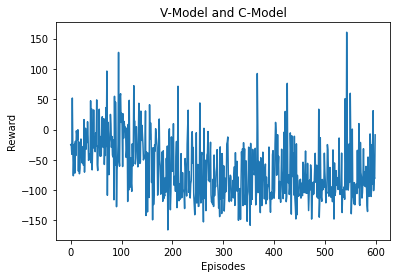

In [29]:
plt.plot(c_model_rewards[:650])
plt.title("V-Model and C-Model")
plt.xlabel("Episodes")
plt.ylabel("Reward")
#plt.savefig("V+C-Training.jpg")

# Train with V, M 

In [14]:
episodes = 600
combined_model_rewards = []
high_action = env.action_space.high
low_action = env.action_space.low
for ep in range(episodes):
    state = env.reset()
    done = False
    episode_rewards = 0
    
    reward_batch = []
    dones_batch = []
    log_prob_batch = []
    hidden_state = (torch.zeros((1, 1, 256)).to(device),torch.zeros((1, 1,  256)).to(device))
    while True:
        
        with torch.no_grad():
            latent_vector_z = V_model.encode_state(state.to(device), return_mu=False)
        
        action, log_prob = c_model.get_action(latent_vector_z, hidden_state)
        action_ = np.asarray(np.clip(action.detach().cpu().numpy(), a_min=low_action, a_max=high_action), dtype=np.float32).squeeze()
        state, reward, done, _ = env.step(action_)

        with torch.no_grad():
            _, hidden_state = m_model.predict_next_z(latent_vector_z.unsqueeze(0), 
                                                     torch.from_numpy(action_).unsqueeze(0).unsqueeze(0).float().to(device), 
                                                     tau=1.1, 
                                                     hidden_state=hidden_state)
        
        reward_batch.append(reward)
        dones_batch.append(1-int(done))
        log_prob_batch.append(log_prob)
        
        
        
        
        episode_rewards += reward
        
        if done:
            break
            
    rewards = calc_discounted_rewards(reward_batch, dones_batch)

    loss = update_cmodel(torch.cat(log_prob_batch, dim=0),
                         torch.FloatTensor(rewards).unsqueeze(-1).to(device))
    
    del(reward_batch)
    del(dones_batch)
    del(log_prob_batch)
    combined_model_rewards.append(episode_rewards)    
            
    print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss), end="", flush=True)
    if ep % 10 == 0:
        print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss))
    env.close()

Track generation: 1121..1410 -> 289-tiles track
Epoch: 0 | Reward: -44.44 | Loss: 0.10
Track generation: 969..1223 -> 254-tiles track
Epoch: 1 | Reward: -44.66 | Loss: 34.69Track generation: 1175..1473 -> 298-tiles track
Epoch: 2 | Reward: -25.93 | Loss: -19.82Track generation: 1202..1506 -> 304-tiles track
Epoch: 3 | Reward: -30.69 | Loss: -7.69Track generation: 1243..1557 -> 314-tiles track
Epoch: 4 | Reward: -29.71 | Loss: -32.70Track generation: 1227..1538 -> 311-tiles track
Epoch: 5 | Reward: -25.81 | Loss: 8.39Track generation: 1236..1550 -> 314-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1046..1321 -> 275-tiles track
Epoch: 6 | Reward: -56.20 | Loss: -0.16Track generation: 1183..1483 -> 300-tiles track
Epoch: 7 | Reward: -26.42 | Loss: 6.62Track generation: 1148..1439 -> 291-tiles track
Epoch: 8 | Reward: -27.59 | Loss: -11.47Track generation: 1042..1312 -> 270-tiles track
Epoch: 9 | Reward: -36.80 | Loss: -5.72Tr

Epoch: 91 | Reward: 22.64 | Loss: 8.54Track generation: 1115..1398 -> 283-tiles track
Epoch: 92 | Reward: -29.08 | Loss: 7.49Track generation: 1094..1372 -> 278-tiles track
Epoch: 93 | Reward: 76.90 | Loss: -13.88Track generation: 1075..1356 -> 281-tiles track
Epoch: 94 | Reward: -17.86 | Loss: 25.54Track generation: 1101..1380 -> 279-tiles track
Epoch: 95 | Reward: -20.86 | Loss: -3.80Track generation: 1156..1449 -> 293-tiles track
Epoch: 96 | Reward: -58.90 | Loss: 20.95Track generation: 1057..1327 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1072..1344 -> 272-tiles track
Epoch: 97 | Reward: -126.09 | Loss: -14.47Track generation: 1185..1496 -> 311-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1180..1479 -> 299-tiles track
Epoch: 98 | Reward: -16.11 | Loss: 8.87Track generation: 1170..1474 -> 304-tiles track
Epoch: 99 | Reward: -60.40 | Loss: -25.24T

Epoch: 258 | Reward: 14.98 | Loss: -1.84Track generation: 1013..1275 -> 262-tiles track
Epoch: 259 | Reward: 91.57 | Loss: 7.15Track generation: 1195..1508 -> 313-tiles track
Epoch: 260 | Reward: 37.82 | Loss: -2.37
Track generation: 1256..1574 -> 318-tiles track
Epoch: 261 | Reward: -108.34 | Loss: -15.36Track generation: 1112..1394 -> 282-tiles track
Epoch: 262 | Reward: 45.91 | Loss: 14.38Track generation: 1090..1367 -> 277-tiles track
Epoch: 263 | Reward: 19.57 | Loss: 21.89Track generation: 1236..1549 -> 313-tiles track
Epoch: 264 | Reward: 98.72 | Loss: -16.41Track generation: 1076..1349 -> 273-tiles track
Epoch: 265 | Reward: 54.41 | Loss: 26.45Track generation: 1165..1460 -> 295-tiles track
Epoch: 266 | Reward: 90.48 | Loss: 11.80Track generation: 1265..1584 -> 319-tiles track
Epoch: 267 | Reward: 6.92 | Loss: -6.36Track generation: 1268..1589 -> 321-tiles track
Epoch: 268 | Reward: -15.63 | Loss: -31.56Track generation: 1306..1637 -> 331-tiles track
Epoch: 269 | Reward: 15.15 

Epoch: 423 | Reward: 40.74 | Loss: -10.50Track generation: 1184..1484 -> 300-tiles track
Epoch: 424 | Reward: 127.42 | Loss: 7.21Track generation: 1057..1325 -> 268-tiles track
Epoch: 425 | Reward: 87.27 | Loss: -32.66Track generation: 1041..1305 -> 264-tiles track
Epoch: 426 | Reward: 67.30 | Loss: 1.02Track generation: 1146..1437 -> 291-tiles track
Epoch: 427 | Reward: 34.48 | Loss: 27.01Track generation: 1164..1466 -> 302-tiles track
Epoch: 428 | Reward: 105.98 | Loss: 19.22Track generation: 1107..1395 -> 288-tiles track
Epoch: 429 | Reward: 136.93 | Loss: -4.59Track generation: 1094..1376 -> 282-tiles track
Epoch: 430 | Reward: 188.26 | Loss: -3.26
Track generation: 1070..1342 -> 272-tiles track
Epoch: 431 | Reward: 117.71 | Loss: -0.00Track generation: 1092..1369 -> 277-tiles track
Epoch: 432 | Reward: 48.55 | Loss: -17.78Track generation: 1015..1273 -> 258-tiles track
Epoch: 433 | Reward: 40.08 | Loss: 5.12Track generation: 1147..1445 -> 298-tiles track
Epoch: 434 | Reward: 27.95

Epoch: 593 | Reward: 210.34 | Loss: 10.01Track generation: 1140..1429 -> 289-tiles track
Epoch: 594 | Reward: 56.11 | Loss: 3.25Track generation: 1086..1362 -> 276-tiles track
Epoch: 595 | Reward: -43.31 | Loss: 8.96Track generation: 1051..1317 -> 266-tiles track
Epoch: 596 | Reward: 96.23 | Loss: -11.86Track generation: 1191..1493 -> 302-tiles track
Epoch: 597 | Reward: 208.97 | Loss: 19.30Track generation: 934..1179 -> 245-tiles track
Epoch: 598 | Reward: 34.93 | Loss: 29.36Track generation: 1272..1595 -> 323-tiles track
Epoch: 599 | Reward: -19.25 | Loss: 48.50

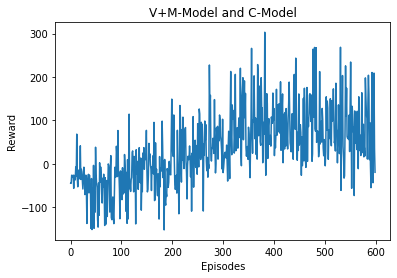

In [16]:
plt.plot(combined_model_rewards)
plt.title("V+M-Model and C-Model")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig("V+M+C-Training_II.jpg")

In [17]:
env.close()